# Multimodal RAG with CLIP Embeddings and GPT-4 Vision


Multimodal RAG integrates additional modalities into traditional text-based RAG, enhancing LLMs' question-answering by providing extra context and grounding textual data for improved understanding.

Adopting the approach from the [clothing matchmaker cookbook](https://cookbook.openai.com/examples/how_to_combine_gpt4v_with_rag_outfit_assistant), we directly embed images for similarity search, bypassing the lossy process of text captioning, to boost retrieval accuracy.

Using CLIP-based embeddings further allows fine-tuning with specific data or updating with unseen images.

This technique is showcased through searching an enterprise knowledge base with user-provided tech images to deliver pertinent information.

# Installations

First let's install the relevant packages.

In [2]:
#installations
%pip install clip
%pip install torch
%pip install pillow
%pip install faiss-cpu
%pip install numpy
%pip install git+https://github.com/openai/CLIP.git
%pip install openai

  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-0.2.0-py3-none-any.whl size=6989 sha256=bd4087e5553f08e83f2974f50eb3ff606431c3f3ca8ad93b758b87d23d8f17b3
  Stored in directory: /root/.cache/pip/wheels/6c/fd/54/9d4e15cf829b871199a7cd3597e869a514d1624a0a43076896
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 81.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6i8smy3s
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6i8smy3s
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=3363afc2f9a21469ab8c23fbd9f90bb87d80d96a53897f8e7a6297b148e7d5a4
  Stored in directory: /tmp/pip-ephem-wheel-cach

Then let's import all the needed packages.


In [3]:
# model imports
import faiss
import json
import torch
from openai import OpenAI
import torch.nn as nn
from torch.utils.data import DataLoader
import clip

import os

if "OPENAI_API_KEY" not in os.environ:
    import getpass
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Paste your OpenAI API key here: ")
client = OpenAI()

# helper imports
from tqdm import tqdm
import json
import os
import numpy as np
import pickle
from typing import List, Union, Tuple

# visualisation imports
from PIL import Image
import matplotlib.pyplot as plt
import base64

Paste your OpenAI API key here: ··········


Now let's load the CLIP model.

In [4]:
#load model on device. The device you are running inference/training on is either a CPU or GPU if you have.
device = "cpu"
model, preprocess = clip.load("ViT-B/32",device=device)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 271MiB/s]



We will now:
1.   Create the image embedding database
2.   Set up a query to the vision model
3.   Perform the semantic search
4.   Pass a user query to the image



# Create image embedding database

Next we will create our image embeddings knowledge base from a directory of images. This will be the knowledge base of technology that we search through to provide information to the user for an image they upload.

We pass in the directory in which we store our images (as JPEGs) and loop through each to create our embeddings.

We also have a description.json. This has an entry for every single image in our knowledge base. It has two keys: 'image_path' and 'description'. It maps each image to a useful description of this image to aid in answering the user question.

First let's write a function to get all the image paths in a given directory. We will then get all the jpeg's from a directory called 'image_database'

In [23]:
def get_image_paths(directory: str, number: int = None) -> List[str]:
    image_paths = []
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith('.jpeg'):
            image_paths.append(os.path.join(directory, filename))
            if number is not None and count == number:
                return [image_paths[-1]]
            count += 1
    return image_paths

#import os
#print(os.getcwd())
#print(os.listdir('/content'))
from google.colab import files
uploaded = files.upload()

direc = '/content'
image_paths = get_image_paths(direc)


Saving Baustelle_1.jpeg to Baustelle_1.jpeg
Saving Baustelle_2.jpeg to Baustelle_2.jpeg
Saving Baustelle_3.jpeg to Baustelle_3.jpeg


Next we will write a function to get the image embeddings from the CLIP model given a series of paths.

We first preprocess the image using the preprocess function we got earlier. This performs a few things to ensure the input to the CLIP model is of the right format and dimensionality including resizing, normalization, colour channel adjustment etc.

We then stack these preprocessed images together so we can pass them into the model at once rather than in a loop. And finally return the model output which is an array of embeddings.

In [24]:
def get_features_from_image_path(image_paths):
  images = [preprocess(Image.open(image_path).convert("RGB")) for image_path in image_paths]
  image_input = torch.tensor(np.stack(images))
  with torch.no_grad():
    image_features = model.encode_image(image_input).float()
  return image_features
image_features = get_features_from_image_path(image_paths)


We can now create our vector database.

In [25]:
index = faiss.IndexFlatIP(image_features.shape[1])
index.add(image_features)


And also ingest our json for image-description mapping and create a list of jsons. We also create a helper function to search through this list for a given image we want, so we can obtain the description of that image

In [27]:
data = []
image_path = 'Baustelle_1.jpeg'
with open('description.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))
def find_entry(data, key, value):
    for entry in data:
        if entry.get(key) == value:
            return entry
    return None

FileNotFoundError: [Errno 2] No such file or directory: 'description.json'

Let us display an example image, this will be the user uploaded image. This is a piece of tech that was unveiled at the 2024 CES. It is the DELTA Pro Ultra Whole House Battery Generator.

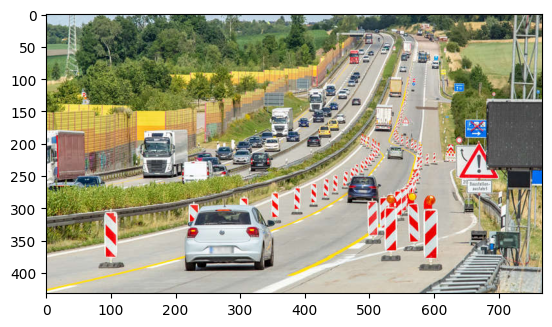

In [28]:
im = Image.open(image_path)
plt.imshow(im)
plt.show()

![Delta Pro](https://github.com/VassiliosPanagiotou/openai-cookbook_vpa/blob/main/images/train1.jpeg?raw=1)

# Querying the vision model

Now let's have a look at what GPT-4 Vision (which wouldn't have seen this technology before) will label it as.



First we will need to write a function to encode our image in base64 as this is the format we will pass into the vision model. Then we will create a generic image_query function to allow us to query the LLM with an image input.

In [35]:
def encode_image(image_path):
    with open(image_path, 'rb') as image_file:
        encoded_image = base64.b64encode(image_file.read())
        return encoded_image.decode('utf-8')

def image_query(query, image_path):
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[
            {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": query,
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encode_image(image_path)}",
                },
                }
            ],
            }
        ],
        max_tokens=300,
    )
    # Extract relevant features from the response
    return response.choices[0].message.content
image_query('Write a short label of what is show in this image?', image_path)

'Highway scene with multiple lanes of traffic, including cars and trucks, partially diverted due to road construction barriers. Vegetation and sound barriers are visible on the sides.'

As we can see, it tries its best from the information it's been trained on but it makes a mistake due to it not having seen anything similar in its training data. This is because it is an ambiguous image making it difficult to extrapolate and deduce.

# Performing semantic search

Now let's perform similarity search to find the two most similar images in our knowledge base. We do this by getting the embeddings of a user inputted image_path, retrieving the indexes and distances of the similar iamges in our database. Distance will be our proxy metric for similarity and a smaller distance means more similar. We then sort based on distance in descending order.

In [36]:
image_search_embedding = get_features_from_image_path([image_path])
distances, indices = index.search(image_search_embedding.reshape(1, -1), 2) #2 signifies the number of topmost similar images to bring back
distances = distances[0]
indices = indices[0]
indices_distances = list(zip(indices, distances))
indices_distances.sort(key=lambda x: x[1], reverse=True)

We require the indices as we will use this to search through our image_directory and selecting the image at the location of the index to feed into the vision model for RAG.

And let's see what it brought back (we display these in order of similarity):

1


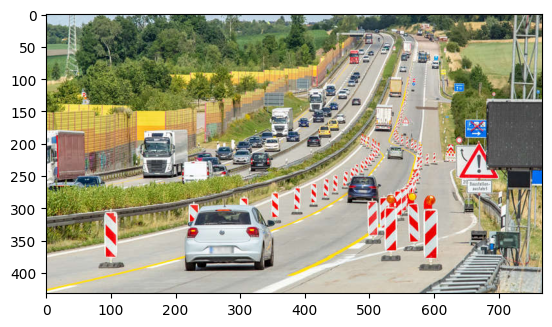

0


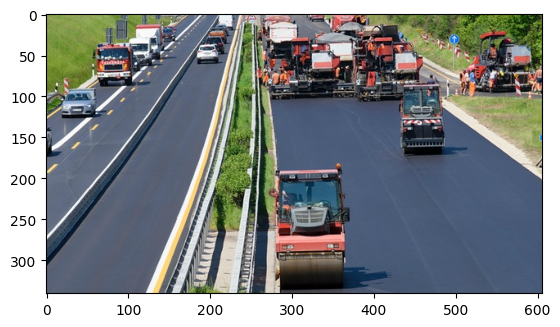

In [37]:
#display similar images
for idx, distance in indices_distances:
    print(idx)
    path = get_image_paths(direc, idx)[0]
    im = Image.open(path)
    plt.imshow(im)
    plt.show()

![Delta Pro2](https://github.com/VassiliosPanagiotou/openai-cookbook_vpa/blob/main/images/train2.jpeg?raw=1)

![Delta Pro3](https://github.com/VassiliosPanagiotou/openai-cookbook_vpa/blob/main/images/train17.jpeg?raw=1)

We can see here it brought back two images which contain the DELTA Pro Ultra Whole House Battery Generator. In one of the images it also has some background which could be distracting but manages to find the right image.

# User querying the most similar image

Now for our most similar image, we want to pass it and the description of it to gpt-v with a user query so they can inquire about the technology that they may have bought. This is where the power of the vision model comes in, where you can ask general queries for which the model hasn't been explicitly trained on to the model and it responds with high accuracy.

In our example below, we will inquire as to the capacity of the item in question.

In [38]:
similar_path = get_image_paths(direc, indices_distances[0][0])[0]
element = find_entry(data, 'image_path', similar_path)

user_query = 'What is the challenge of this situation?'
prompt = f"""
Below is a user query, I want you to answer the query using the description and image provided.

user query:
{user_query}

description:
{element['description']}
"""
image_query(prompt, similar_path)

NameError: name 'find_entry' is not defined

And we see it is able to answer the question. This was only possible by matching images directly and from there gathering the relevant description as context.

# Conclusion

In this notebook, we have gone through how to use the CLIP model, an example of creating an image embedding database using the CLIP model, performing semantic search and finally providing a user query to answer the question.

The applications of this pattern of usage spread across many different application domains and this is easily improved to further enhance the technique. For example you may finetune CLIP, you may improve the retrieval process just like in RAG and you can prompt engineer GPT-V.
